<a href="https://colab.research.google.com/github/towardsai/ai-tutor-rag-system/blob/main/notebooks/15-Use_OpenSource_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Packages and Setup Variables

In [ ]:
# !pip install -q llama-index==0.14.0 openai==1.107.0 llama-index-llms-google-genai==0.5.0 chromadb==1.0.21 \
#                 llama-index-vector-stores-chroma==0.5.3 llama-index-finetuning==0.4.1 llama-index-llms-together==0.4.1 \
#                 llama-index-embeddings-huggingface==0.6.1 jedi==0.19.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/67.3 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 951.0/951.0 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.3/303.3 kB 18.6 MB/s eta 0:00:0

In [ ]:
# uv add -U llama-index-finetuning llama-index-llms-together llama-index-embeddings-huggingface

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

# Set environment variables for the API keys
# os.environ["OPENAI_API_KEY"] = "<YOUR_API_KEY>"
# os.environ["TOGETHER_AI_API_TOKEN"] = "<YOUR_API_KEY>"
# os.environ["GOOGLE_API_KEY"] = "<YOUR_API_KEY>"

# from google.colab import userdata
# os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
# os.environ["GOOGLE_API_KEY"] = userdata.get('Google_api_key')
# os.environ["TOGETHER_AI_API_TOKEN"] = userdata.get('together_api_key')


True

In [2]:
# Allows running asyncio in environments with an existing event loop, like Jupyter notebooks.
import nest_asyncio

nest_asyncio.apply()

# Create a vector store and ingest articles

In [8]:
# import chromadb
# from llama_index.vector_stores.chroma import ChromaVectorStore

from qdrant_client import QdrantClient, AsyncQdrantClient, models as qdrant_models
from llama_index.vector_stores.qdrant import QdrantVectorStore


# vector_store_name = "mini-llama-articles"
# chroma_client = chromadb.PersistentClient(path=vector_store_name)
# chroma_collection = chroma_client.get_or_create_collection(vector_store_name)
# vector_store = ChromaVectorStore(chroma_collection=chroma_collection)


# create vector store
collection_name = "mini-llama-articles_15"

qdrant_client = QdrantClient(url=f"http://{os.getenv('qdrant_server_id')}:6333", prefer_grpc=True)
async_qdrant_client = AsyncQdrantClient(url=f"http://{os.getenv('qdrant_server_id')}:6333", prefer_grpc=True)

if qdrant_client.collection_exists(collection_name=collection_name):
    collection = qdrant_client.get_collection(collection_name=collection_name)
else:
    collection = qdrant_client.create_collection(
        collection_name=collection_name,
        vectors_config=qdrant_models.VectorParams(
            size=384,  # dimension of the embedding model
            distance=qdrant_models.Distance.COSINE,
        ),
    )

In [4]:
qdrant_client.get_collection(collection_name)

CollectionInfo(status=<CollectionStatus.GREEN: 'green'>, optimizer_status=<OptimizersStatusOneOf.OK: 'ok'>, vectors_count=None, indexed_vectors_count=0, points_count=108, segments_count=3, config=CollectionConfig(params=CollectionParams(vectors=VectorParams(size=384, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None), shard_number=1, sharding_method=None, replication_factor=1, write_consistency_factor=1, read_fan_out_factor=None, on_disk_payload=True, sparse_vectors=None), hnsw_config=HnswConfig(m=16, ef_construct=100, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segment_number=0, max_segment_size=None, memmap_threshold=None, indexing_threshold=10000, flush_interval_sec=5, max_optimization_threads=None), wal_config=WalConfig(wal_capacity_mb=32, wal_segments_ahead=0), qua

In [5]:
vector_store = QdrantVectorStore(client=qdrant_client, aclient=async_qdrant_client, collection_name=collection_name)

Both client and aclient are provided. If using `:memory:` mode, the data between clients is not synced.


The dataset includes several articles from the TowardsAI blog, which provide an in-depth explanation of the LLaMA2 model. Read the dataset as a long string.

In [ ]:
# !curl -o ./mini-llama-articles.csv https://raw.githubusercontent.com/AlaFalaki/tutorial_notebooks/main/data/mini-llama-articles.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  169k  100  169k    0     0   651k      0 --:--:-- --:--:-- --:--:--  652k


## Read articles from file

In [6]:
import csv
from llama_index.core import Document

rows = []

# Load the file as a JSON
with open("./mini-llama-articles.csv", mode="r", encoding="utf-8") as file:
  csv_reader = csv.reader(file)

  for idx, row in enumerate( csv_reader ):
    if idx == 0: continue; # Skip header row
    rows.append(row)

        # Convert the chunks to Document objects so the LlamaIndex framework can process them.
documents = [
    Document(
        text=row[1], metadata={"title": row[0], "url": row[2], "source_name": row[3]}
    )
    for row in rows
]

## Ingest documents into vector store

In [7]:

from llama_index.core.text_splitter import TokenTextSplitter, SentenceSplitter
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.ingestion import IngestionPipeline


# Define the splitter object that split the text into segments with 512 tokens,
# with a 128 overlap between the segments.
text_splitter = TokenTextSplitter(
    separator=" ", chunk_size=512, chunk_overlap=128
)

# Create the pipeline to apply the transformation on each chunk,
# and store the transformed text in the chroma vector store.
pipeline = IngestionPipeline(
    transformations=[
        text_splitter,
        HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5") # Or, OpenAIEmbedding()
    ],
    vector_store=vector_store
)

In [9]:
nodes = pipeline.run(documents=documents, show_progress=True)

Parsing nodes:   0%|          | 0/14 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/108 [00:00<?, ?it/s]

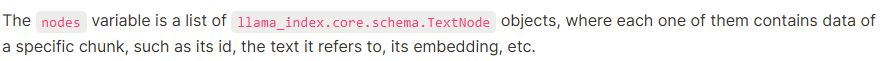

### Save and Load Nodes

In [10]:
import pickle

# Save nodes to disk
with open("./nodes_15.pkl", "wb") as f:
    pickle.dump(nodes, f)

# # Load nodes from disk
# with open("./nodes_15.pkl", "rb") as f:
#     nodes = pickle.load(f)

In [11]:
import pickle

my_list = [1, 2, 3, {"a": 10, "b": 20}]

pickled_bytes = pickle.dumps(my_list)
print(f"Pickled bytes: {pickled_bytes}")
print(f"Type of pickled_bytes: {type(pickled_bytes)}")


Pickled bytes: b'\x80\x04\x95\x1b\x00\x00\x00\x00\x00\x00\x00]\x94(K\x01K\x02K\x03}\x94(\x8c\x01a\x94K\n\x8c\x01b\x94K\x14ue.'
Type of pickled_bytes: <class 'bytes'>


In [12]:
import pickle

# Using the pickled_bytes from the previous example
my_list = [1, 2, 3, {"a": 10, "b": 20}]
pickled_bytes = pickle.dumps(my_list)

unpickled_list = pickle.loads(pickled_bytes)
print(f"Unpickled list: {unpickled_list}")
print(f"Type of unpickled_list: {type(unpickled_list)}")


Unpickled list: [1, 2, 3, {'a': 10, 'b': 20}]
Type of unpickled_list: <class 'list'>


# Load vector store and create query engine

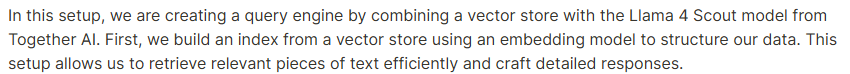

In [23]:
from llama_index.core.prompts import PromptTemplate
from llama_index.llms.together import TogetherLLM
from llama_index.core import VectorStoreIndex

# Use the Together AI service to access the Llama chat model
llm = TogetherLLM(
    model="meta-llama/Llama-4-Scout-17B-16E-Instruct",
    api_key=os.environ["TOGETHER_AI_API_TOKEN"]
)

# create index from vector store
index = VectorStoreIndex.from_vector_store(vector_store, embed_model="local:BAAI/bge-small-en-v1.5")

# Define a query engine that is responsible for retrieving related pieces of text,
# and using a LLM to formulate the final answer.
query_engine = index.as_query_engine(llm=llm)

# Test query engine

In [12]:
res = query_engine.query("How many parameters LLaMA 2 has?")
print(res.response)
# 'Llama 2 is available in four different model sizes: 7 billion, 13 billion, 34 billion, and 70 billion parameters.'

Llama 2 is available in four different model sizes: 7 billion, 13 billion, 34 billion, and 70 billion parameters.


In [13]:
# print the source nodes used to write the answer
for src in res.source_nodes:
  print("Node ID\t", src.node_id)
  print("Title\t", src.metadata['title'])
  print("Text\t", src.text)
  print("Score\t", src.score)
  print("-_"*20)

Node ID	 fcea7d70-152c-4bf5-87fb-8af0a2ad96d6
Title	 Meta's Llama 2: Revolutionizing Open Source Language Models for Commercial Use
Text	 I. Llama 2: Revolutionizing Commercial Use Unlike its predecessor Llama 1, which was limited to research use, Llama 2 represents a major advancement as an open-source commercial model. Businesses can now integrate Llama 2 into products to create AI-powered applications. Availability on Azure and AWS facilitates fine-tuning and adoption. However, restrictions apply to prevent exploitation. Companies with over 700 million active daily users cannot use Llama 2. Additionally, its output cannot be used to improve other language models.  II. Llama 2 Model Flavors Llama 2 is available in four different model sizes: 7 billion, 13 billion, 34 billion, and 70 billion parameters. While 7B, 13B, and 70B have already been released, the 34B model is still awaited. The pretrained variant, trained on a whopping 2 trillion tokens, boasts a context window of 4096 toke

# Evaluate the retriever

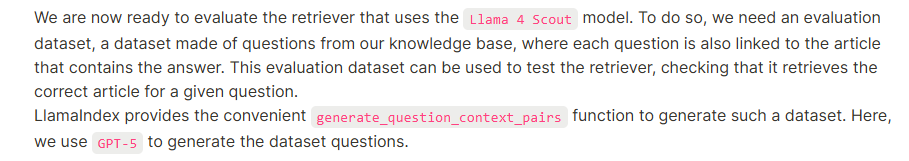

In [15]:
from llama_index.core.evaluation import generate_question_context_pairs
from llama_index.llms.openai import OpenAI
from llama_index.llms.openrouter import OpenRouter

# Create questions for each segment. These questions will be used to
# assess whether the retriever can accurately identify and return the
# corresponding segment when queried.
# llm = OpenAI(model="gpt-5", additional_kwargs={"reasoning_effort": "minimal"})

llm = OpenRouter(
    model="openai/gpt-5",
    max_tokens=512,
    temperature=0.3,
    api_key=os.getenv("OPENROUTER_API_KEY"),
    additional_kwargs={"reasoning_effort": "minimal"}
)

rag_eval_dataset = generate_question_context_pairs(
    nodes,
    llm=llm,
    num_questions_per_chunk=1
)

  0%|          | 0/108 [00:00<?, ?it/s]

100%|██████████| 108/108 [10:50<00:00,  6.03s/it]


In [16]:
# We can save the evaluation dataset as a json file for later use.
rag_eval_dataset.save_json("./rag_eval_dataset_15.json")

If you have uploaded the generated question JSON file, please uncomment the code in the next cell block. This will avoid the need to generate the questions manually, saving you time and effort.

In [17]:
#from llama_index.finetuning.embeddings.common import EmbeddingQAFinetuneDataset

from llama_index.core.evaluation import EmbeddingQAFinetuneDataset

rag_eval_dataset = EmbeddingQAFinetuneDataset.from_json(
    "./rag_eval_dataset_15.json"
)

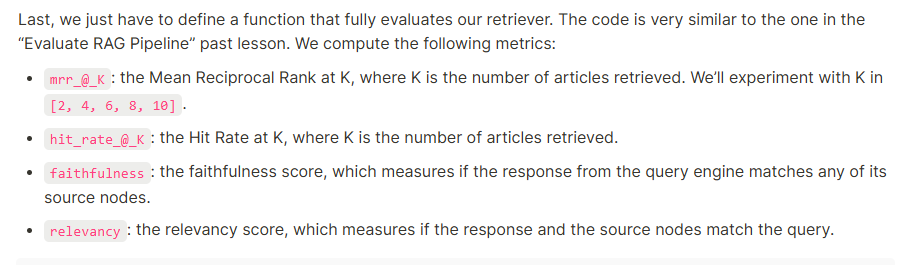

In [25]:
import asyncio
from llama_index.core.evaluation import RetrieverEvaluator, RelevancyEvaluator, FaithfulnessEvaluator, BatchEvalRunner
from llama_index.llms.openai import OpenAI

async def run_evaluation(index, rag_eval_dataset, top_k_values, llm_judge, llm, n_queries_to_evaluate=20, num_work=1):
    evaluation_results = {}

    # ------------------- MRR and Hit Rate -------------------

    for top_k in top_k_values:
        # Get MRR and Hit Rate
        retriever = index.as_retriever(similarity_top_k=top_k)
        retriever_evaluator = RetrieverEvaluator.from_metric_names(
            ["mrr", "hit_rate"], retriever=retriever
        )
        eval_results = await retriever_evaluator.aevaluate_dataset(rag_eval_dataset)
        avg_mrr = sum(res.metric_vals_dict["mrr"] for res in eval_results) / len(eval_results)
        avg_hit_rate = sum(res.metric_vals_dict["hit_rate"] for res in eval_results) / len(eval_results)

        # Collect the evaluation results
        evaluation_results[f"mrr_@_{top_k}"] = avg_mrr
        evaluation_results[f"hit_rate_@_{top_k}"] = avg_hit_rate

    # ------------------- Faithfulness and Relevancy -------------------

    # Extract the questions from the dataset
    queries = list(rag_eval_dataset.queries.values())
    batch_eval_queries = queries[:n_queries_to_evaluate]

    # Initiate the faithfulnes and relevancy evaluator objects
    faithfulness_evaluator = FaithfulnessEvaluator(llm=llm_judge)
    relevancy_evaluator = RelevancyEvaluator(llm=llm_judge)

    # The batch evaluator runs the evaluation in batches
    runner = BatchEvalRunner(
        {
            "faithfulness": faithfulness_evaluator,
            "relevancy": relevancy_evaluator
        },
        workers=num_work,
        show_progress=True,
    )

    # Get faithfulness and relevancy scores
    query_engine = index.as_query_engine(llm=llm)
    eval_results = await runner.aevaluate_queries(
        query_engine, queries=batch_eval_queries
    )
    faithfulness_score = sum(result.passing for result in eval_results['faithfulness']) / len(eval_results['faithfulness'])
    relevancy_score = sum(result.passing for result in eval_results['relevancy']) / len(eval_results['relevancy'])
    evaluation_results["faithfulness"] = faithfulness_score
    evaluation_results["relevancy"] = relevancy_score

    return evaluation_results

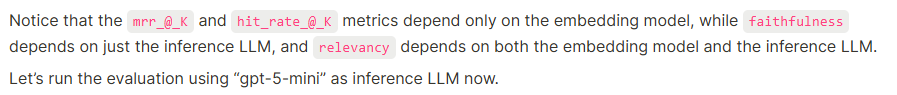

In [26]:
# We evaluate the retrievers with different top_k values.
top_k_values = [2, 4, 6, 8, 10]

# llm_judge = OpenAI(model="gpt-5",additional_kwargs={"reasoning_effort":"minimal"})
llm_judge = OpenRouter(
    model="openai/gpt-5",
    api_key=os.getenv("OPENROUTER_API_KEY"),
    additional_kwargs={"reasoning_effort":"minimal"}
)

evaluation_results = await run_evaluation(index, rag_eval_dataset, top_k_values, llm_judge,llm=llm,n_queries_to_evaluate=20,num_work=1)

100%|██████████| 40/40 [02:27<00:00,  3.68s/it]


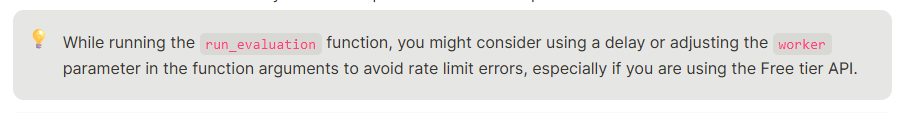

In [27]:
print(evaluation_results)

{'mrr_@_2': 0.8194444444444444, 'hit_rate_@_2': 0.9259259259259259, 'mrr_@_4': 0.8341049382716049, 'hit_rate_@_4': 0.9722222222222222, 'mrr_@_6': 0.8356481481481481, 'hit_rate_@_6': 0.9814814814814815, 'mrr_@_8': 0.8356481481481481, 'hit_rate_@_8': 0.9814814814814815, 'mrr_@_10': 0.8356481481481481, 'hit_rate_@_10': 0.9814814814814815, 'faithfulness': 1.0, 'relevancy': 1.0}


ORIGINAL:
{'mrr_@_2': 0.8055555555555556, 'hit_rate_@_2': 0.8981481481481481, 'mrr_@_4': 0.83179012345679, 'hit_rate_@_4': 0.9814814814814815, 'mrr_@_6': 0.8336419753086419, 'hit_rate_@_6': 0.9907407407407407, 'mrr_@_8': 0.8349647266313932, 'hit_rate_@_8': 1.0, 'mrr_@_10': 0.8349647266313932, 'hit_rate_@_10': 1.0, 'faithfulness': 0.9, 'relevancy': 1.0}

## constants.py in LlamaIndex  
DEFAULT_TEMPERATURE = 0.1  
DEFAULT_CONTEXT_WINDOW = 3900  # tokens  
DEFAULT_NUM_OUTPUTS = 256  # tokens  
DEFAULT_NUM_INPUT_FILES = 10  # files  

DEFAULT_EMBED_BATCH_SIZE = 10

DEFAULT_CHUNK_SIZE = 1024  # tokens  
DEFAULT_CHUNK_OVERLAP = 20  # tokens  
DEFAULT_SIMILARITY_TOP_K = 2  
DEFAULT_IMAGE_SIMILARITY_TOP_K = 2  

### NOTE: for text-embedding-ada-002  
DEFAULT_EMBEDDING_DIM = 1536

### context window size for llm predictor  
COHERE_CONTEXT_WINDOW = 2048
AI21_J2_CONTEXT_WINDOW = 8192  


TYPE_KEY = "__type__"  
DATA_KEY = "__data__"  
VECTOR_STORE_KEY = "vector_store"  
IMAGE_STORE_KEY = "image_store"  
GRAPH_STORE_KEY = "graph_store"  
INDEX_STORE_KEY = "index_store"  
DOC_STORE_KEY = "doc_store"  
PG_STORE_KEY = "property_graph_store"

### llama-cloud constants  
DEFAULT_PIPELINE_NAME = "default"  
DEFAULT_PROJECT_NAME = "Default"  
DEFAULT_BASE_URL = "https://api.cloud.llamaindex.ai"  
DEFAULT_APP_URL = "https://cloud.llamaindex.ai"


In [29]:
# Use GPT-5-mini as the LLM inference model
# llm = OpenAI(model="gpt-5-mini", additional_kwargs={"reasoning_effort":"minimal"})

llm = OpenRouter(
    model="openai/gpt-5-mini",
    # max_tokens=512,
    # temperature=0.3,
    api_key=os.getenv("OPENROUTER_API_KEY"),
    additional_kwargs={"reasoning_effort":"minimal"}
)

# run evaluation with GPT-5
top_k_values = [2, 4, 6, 8, 10]
# llm_judge = OpenAI(temperature=0, model="gpt-5",additional_kwargs={"reasoning_effort":"minimal"})
llm_judge = OpenRouter(
    model="openai/gpt-5",
    api_key=os.getenv("OPENROUTER_API_KEY"),
    additional_kwargs={"reasoning_effort":"minimal"}
)

evaluation_results = await run_evaluation(index, rag_eval_dataset, top_k_values, llm_judge,llm=llm, n_queries_to_evaluate=20,num_work=16)

100%|██████████| 40/40 [00:14<00:00,  2.78it/s]


In [30]:
print(evaluation_results)

{'mrr_@_2': 0.8194444444444444, 'hit_rate_@_2': 0.9259259259259259, 'mrr_@_4': 0.8341049382716049, 'hit_rate_@_4': 0.9722222222222222, 'mrr_@_6': 0.8356481481481481, 'hit_rate_@_6': 0.9814814814814815, 'mrr_@_8': 0.8356481481481481, 'hit_rate_@_8': 0.9814814814814815, 'mrr_@_10': 0.8356481481481481, 'hit_rate_@_10': 0.9814814814814815, 'faithfulness': 0.95, 'relevancy': 0.95}


ORIGINAL results:
{'mrr_@_2': 0.8055555555555556, 'hit_rate_@_2': 0.8981481481481481, 'mrr_@_4': 0.83179012345679, 'hit_rate_@_4': 0.9814814814814815, 'mrr_@_6': 0.8336419753086419, 'hit_rate_@_6': 0.9907407407407407, 'mrr_@_8': 0.8349647266313932, 'hit_rate_@_8': 1.0, 'mrr_@_10': 0.8349647266313932, 'hit_rate_@_10': 1.0, 'faithfulness': 1.0, 'relevancy': 1.0}

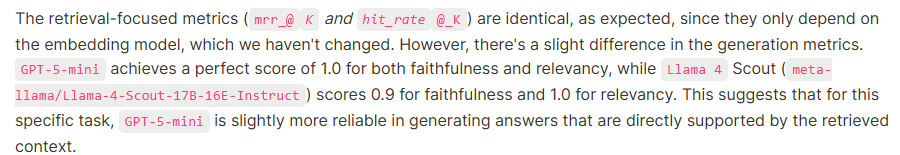

In [32]:
# from llama_index.llms.google_genai import GoogleGenAI

# # Use Gemini as the LLM model
# import google.genai.types as types

# config = types.GenerateContentConfig(thinking_config=types.ThinkingConfig(thinking_budget=0))

# llm = GoogleGenAI(model="gemini-2.5-flash", generation_config=config)
llm = OpenRouter(
    model="google/gemini-2.5-flash",
    api_key=os.getenv("OPENROUTER_API_KEY"),
    additional_kwargs={"reasoning_effort":"minimal"}
)

# # run evaluation with Gemini
top_k_values = [2, 4, 6, 8, 10]
llm_judge = OpenRouter(
	temperature=0,
	 model="openai/gpt-5",
	api_key=os.getenv("OPENROUTER_API_KEY"),
	additional_kwargs={"reasoning_effort":"minimal"}
)
evaluation_results = await run_evaluation(index, rag_eval_dataset, top_k_values, llm_judge,llm=llm, n_queries_to_evaluate=20,num_work=1)

100%|██████████| 40/40 [03:46<00:00,  5.65s/it]


In [33]:
print(evaluation_results)

{'mrr_@_2': 0.8194444444444444, 'hit_rate_@_2': 0.9259259259259259, 'mrr_@_4': 0.8341049382716049, 'hit_rate_@_4': 0.9722222222222222, 'mrr_@_6': 0.8356481481481481, 'hit_rate_@_6': 0.9814814814814815, 'mrr_@_8': 0.8356481481481481, 'hit_rate_@_8': 0.9814814814814815, 'mrr_@_10': 0.8356481481481481, 'hit_rate_@_10': 0.9814814814814815, 'faithfulness': 0.95, 'relevancy': 1.0}


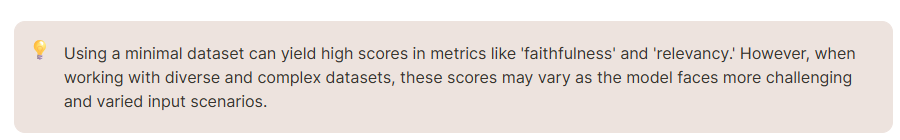

# Inference speed comparison

In [34]:
import time

In [39]:
llm = TogetherLLM(
    model="meta-llama/Llama-4-Scout-17B-16E-Instruct",
    api_key=os.environ["TOGETHER_AI_API_TOKEN"]
)

time_start = time.time()
llm.complete("List the 50 states in the United States of America. Write their names in a comma-separated list and nothing else.")
time_end = time.time()
print("Time taken for Llama 4 Scout on Together AI: {0:.2f} seconds".format(time_end - time_start))

Time taken for Llama 4 Scout on Together AI: 2.62 seconds


In [37]:
# llm = OpenAI(model="gpt-5-mini", additional_kwargs={"reasoning_effort":"minimal"})
llm = OpenRouter(
    model="openai/gpt-5-mini",
    # max_tokens=512,
    # temperature=0.3,
    api_key=os.getenv("OPENROUTER_API_KEY"),
    additional_kwargs={"reasoning_effort":"minimal"}
)

time_start = time.time()
llm.complete("List the 50 states in the United States of America. Write their names in a comma-separated list and nothing else.")
time_end = time.time()
print("Time taken for GPT 5 Mini: {0:.2f} seconds".format(time_end - time_start))

Time taken for GPT 5 Mini: 4.03 seconds


In [38]:
# from llama_index.llms.google_genai import GoogleGenAI
# import google.genai.types as types

# config = types.GenerateContentConfig(thinking_config=types.ThinkingConfig(thinking_budget=0))

# llm = GoogleGenAI(model="gemini-2.5-flash", generation_config=config)

llm = OpenRouter(
    model="google/gemini-2.5-flash",
    api_key=os.getenv("OPENROUTER_API_KEY"),
    additional_kwargs={"reasoning_effort":"minimal"}
)

time_start = time.time()
llm.complete("List the 50 states in the United States of America. Write their names in a comma-separated list and nothing else.")
time_end = time.time()
print("Time taken for Gemini 2.5 Flash: {0:.2f} seconds".format(time_end - time_start))

Time taken for Gemini 2.5 Flash: 1.65 seconds


### STRANGE RESULTS: CHECK LATER

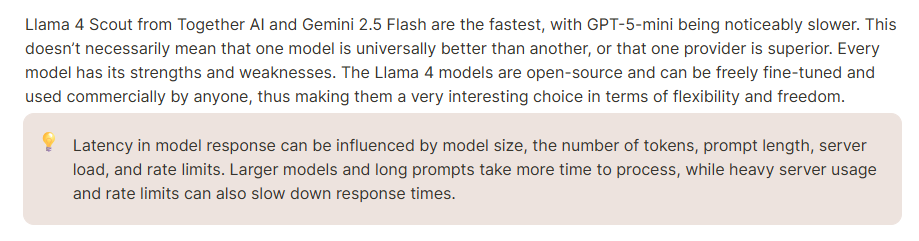

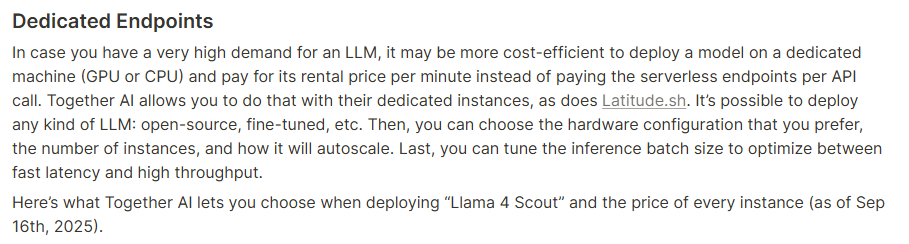

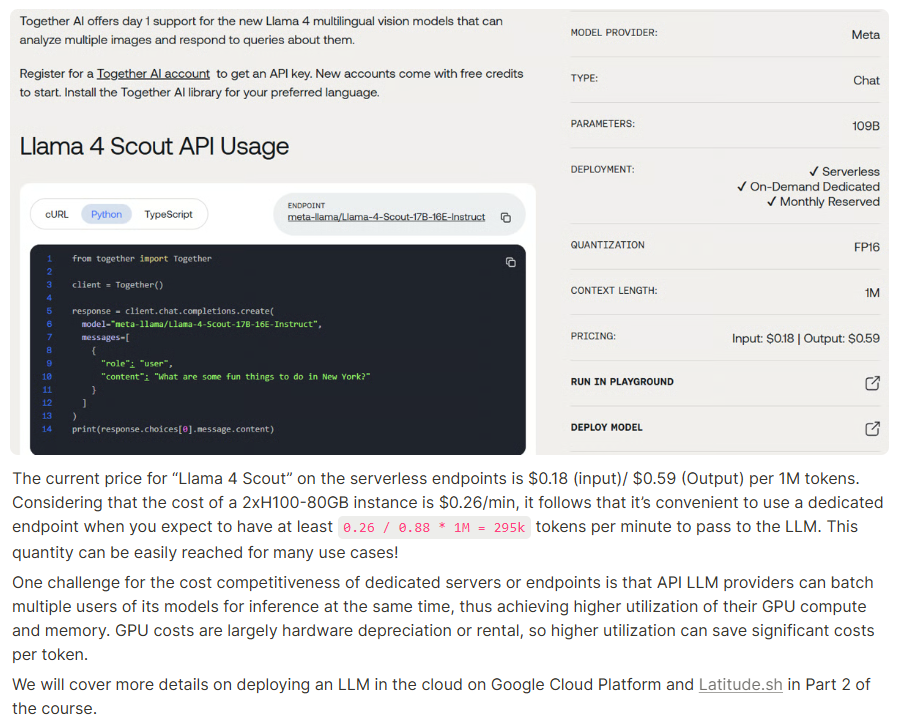